## The goal of this notebook is to test the optimization of DS sample paths.

Let's start by creating a dummy GP model.

Using a 1D model for ease of plotting sample paths.

In [1]:
import torch
import gpytorch
import botorch

device = "cuda" if torch.cuda.is_available() else "cpu"

num_train = 20
dim = 1
train_X = torch.rand(num_train, dim, device=device)
train_Y = torch.randn(num_train, 1, device=device)

model = botorch.models.SingleTaskGP(
    train_X, train_Y,
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = botorch.fit_gpytorch_model(mll)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Construct the decoupled sampler for this model.

We will focus on a single sample path to simplify grad operations.

In [2]:
from gp_sampling import decoupled_sampler

ds = decoupled_sampler(
    model=model,
    sample_shape=torch.Size([1]),
    num_basis=256,
)

# dummy test
print(ds(torch.rand(2, dim, device=device)).shape)

torch.Size([1, 2, 1])


Let's check whether the output has grad.

In [3]:
test_X = torch.rand(2, dim, device=device, requires_grad=True)
samples = ds(test_X)

print(f"Samples: {samples}, \n"
      f"requires grad: {samples.requires_grad}")

grad = torch.autograd.grad(samples.sum(), test_X)
print(f"Grad: {grad}")


Samples: tensor([[[-1.9555],
         [ 0.4391]]], grad_fn=<AddBackward0>), 
requires grad: True
Grad: (tensor([[-1.6371],
        [ 2.4491]]),)


Let's plot the sample path and see if simple gradient descent gets us to a local
minimizer.

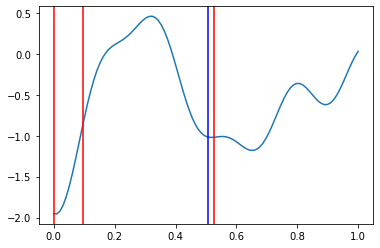

In [4]:
import matplotlib.pyplot as plt

if dim != 1:
    raise RuntimeError("Cannot plot sample paths with dim > 1!")

plot_X = torch.linspace(0, 1, 100).to(device).reshape(-1, 1)
plot_Y = ds(plot_X).reshape(-1, 1)
plt.plot(
    plot_X.detach().cpu(), plot_Y.detach().cpu()
)

X = torch.rand(1, 1, device=device, requires_grad=True)
lr = 0.05

for i in range(1000):
    Y = ds(X)
    g = torch.autograd.grad(Y, X)[0]
    X = X - lr * g
    X = X.clamp(0, 1)

plt.axvline(X.detach().cpu(), c="b")

# How about multi-start SGD?

X = torch.rand(3, 1, device=device, requires_grad=True)

for i in range(1000):
    Y = ds(X)
    g = torch.autograd.grad(Y.sum(), X)[0]
    X = X - lr * g
    X = X.clamp(0, 1)

for x_ in X:
    plt.axvline(x_.detach().cpu(), c="r")


Step size appears to be a factor here. To rule this out, let's try using LBFGS via
BoTorch.

Note that this maximizes whereas the previous ones were minimization.

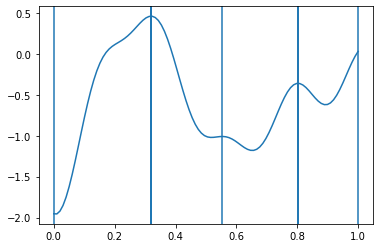

In [5]:
# plot the sample path
plot_X = torch.linspace(0, 1, 100).to(device).reshape(-1, 1)
plot_Y = ds(plot_X).reshape(-1, 1)
plt.plot(
    plot_X.detach().cpu(), plot_Y.detach().cpu()
)

solutions, values = botorch.gen_candidates_scipy(
    initial_conditions=torch.linspace(0, 1, 10).to(device).reshape(-1, 1),
    acquisition_function=ds,
    lower_bounds=0.,
    upper_bounds=1.,
)

for x_ in solutions:
    plt.axvline(x_.detach().cpu())